In [56]:
##Install unidecode function
!pip install unidecode

In [58]:
#Import the following packages so we are able to turn any unidecode characters into plain ASCII. 
#We then will be able to view the number of characters in our dataset (Prepare our data)import unidecode
import string
import random
import re
import os
import torch

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('/Users/mattrusso/Desktop/coldplay.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 125131


In [59]:
#I used random seed just to initialize the random number generator (optional)
import random
random.seed(5)

#Chunk set to 300 characters is going to let us see a random portion of the dataset. 
#Any value works as long as it is within the total number of characters in your dataset.
chunk_len = 300

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

t about to lose our home
Diamonds ate the radio
Moving in the dead of night
We took photographs just some just so
History has some to know
We were moving at the speed of flight

Kids cry
If you want to
That's alright
If you want to
Hold me
Hold me tight

Just an alien

We were hovering without a home


In [60]:
#Import the following
import torch
import torch.nn as nn
from torch.autograd import Variable

#Build the model
#A dropout layer was added of 0.75 in the GRU layer to minimize the impact of overfitting

input_size = 400
hidden_size =370
output_size = 510
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=2):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=0.5)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [61]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


In [62]:
#This assembles a pair of input/target tensors for training from the random chunk.
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [63]:
#Evaluate the network - we used one character at a time ('A') but you can play around with this step. 
#Also depends on the dataset you work with

def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [64]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [65]:
#Below we run the main training function:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [66]:
#Then we define the training parameters, instantiate the model, and start training:

n_epochs = 10000
seq_length = 175
decay_rate = 0.97
print_every = 100
plot_every = 10
hidden_size = 370
n_layers = 2
lr = 0.001

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


 12s (100 1%) 2.0680]
Whaih

ouse
Shere lingo polle nithes mer me noal dis,
Yout heay oll uand ann
There me come ith fes tor 

 24s (200 2%) 2.0130]
When's nes beer there I face
And wion, jut oh it wait's won't take where hen to gounn

And how every f 

 37s (300 3%) 1.8936]
Whes for you get stat the me trumes as been a keen they don
Oh you're a gonna neas the're
Sor cear
Hov 

 49s (400 4%) 1.7046]
When there's alrigh
And it wave we don't right
To lime sing, my stry fills
From you lealiate feet me a 

 2s (500 5%) 1.4218]
When tho my shaper mys that he
And I shete goo
You'd the's pload, the this love so fill
And whtear who 

 14s (600 6%) 1.6822]
When the want your call I coll
When the marm for in my crame shay
I'm nom love you

Set but I, I'm pre 

 26s (700 7%) 1.5844]
Where toh oh
So my singing
But the chance of there I'll feel be back a beginna reasid and I cares

Or  

 39s (800 8%) 1.4168]
When when you ever want, someone a life and to for can
Oh, you want my liktion now
oh and 

 59s (6300 63%) 0.7785]
What it's of myself in the sypleet

Singing lough so high that I mine

I sat you same

Could it be ali 

 11s (6400 64%) 1.1450]
When these bey bly and say yes
You ame never came somewar
And worte it world
But it was a line, when t 

 23s (6500 65%) 0.6921]
Where roubles harmone

So if you only nothing make somebody
Someones listent to day
And I'm cry, and d 

 36s (6600 66%) 0.6691]
What you come.
Oh, oh, oh, oh oh oh
Ooh ooh
Oooh, ooh-ooh, ooh, oh, oh, oh

'Cause you'll never feel n 

 48s (6700 67%) 0.8673]
What do come over too
Been my hands the streams Gillsed the marbies, of way
I think is feel
It's no lo 

 1s (6800 68%) 1.0821]
Where do we got a tried they're just arms
Oh I'll shiver
Now I can true

I could be time
If you can th 

 13s (6900 69%) 0.8027]
When you think it was in my tum
Letting's just like the crust hurts of float ons of strum

Maybe I'm n 

 25s (7000 70%) 1.2696]
What one of it races
It's a whose I said
I wanna get it to kaited the star

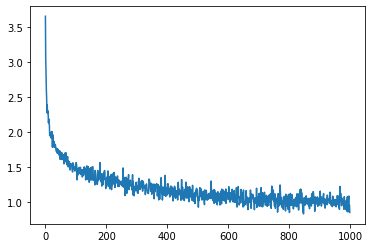

In [70]:
##The code below is plotting the historical loss from all_losses shows the network learning:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

This is where the temperature argument comes into play (see report for in-depth explanation). Using a lower value (less than 1) makes high probabilities contribute more. The closer we get to 0 = the more likely outputs we will se. You can experiemnt with the temp argument value to see the impact it has on generating lyrics. I used 0.21 as it generated lyrics that flowed the best. See paper for more as mentioned earlier. 

In [90]:
print(evaluate("Always", 400, temperature=0.21))

Always be waiting

When I want anybody listening

Oh now what I do
And I want something just like this
I wanna live in a bubble

Confusion in the sun
And I can't explode

Cause I can't let go back and I'm gonna buy this plain
I know you see
I was lost and dart
And I can't touch the ground
Now my feet won't touch the world

Hear I can the day
And I want to change my face
I wanna live in a bubbe

Can we c


In [104]:
print(evaluate("Love", 400, temperature=0.20))

Love it all
Like a light on
Leave a light, and I don't know
So much that I can't see

Oh oh oh oh oh oh oh

In the car fire
I want to see a corner want to be something me
And I wanna live in
And I know that I know the streets

And the night what the stars and give me on your own
And I can't let me go

Up and I know
Gonna get it together

Come on yeah

And I wanna live in a light

So here I can for you


The next set of lyrics I was able to create was my favorite. I saw the best flow and you can really understand the writing style Coldplay has. You can identify that in the previous two generated lyrics too but this one I really enjoyed seeing. 

In [83]:
print(evaluate("After the night", 800, temperature=0.21))

After the night
Let me the water and flew
Like a bigger and matter
This way I'm so high
It's a wonderful life
Never felt so alive
Never felt so light
I was a fight on
Leave a light, a light on
Leave a light on

Listen and sing

Oh, I want to see the ground
Now my feet won't touch the ground
Now my feet won't let me gone

Up in flames

We said for me the crossed in my ghost
You're things that I can the drive
Yes I wanna live in
And I want a start a whisper, a whisper, a whisper, a whisper, a whisper, a whisper
He are to pull me and shate
And I want to change
I wanna be the world
And we don't wanna be the dawn
I wanna live in a bubble

Confidence in this things this

I want to came here to be say
It down the world
How money's all bring
"ever all alright
It doesn't mean I'm alright
It's true
I don't miss
I 
